# Speech Commands Dataset

This dataset contains over 105,000 WAV files of people saying 30 different words in one second audio clips. This largely follows the tutorial <a href="https://www.tensorflow.org/tutorials/audio/simple_audio">here</a>.

## Imports

In [11]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Importing and Processing the Dataset

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
Total Number of Examples: 8000
Number of Examples per Label: 1000


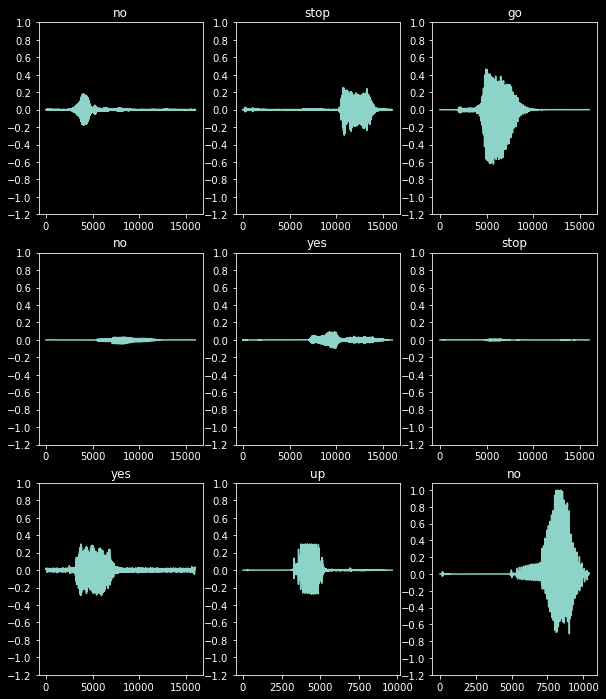

Label: no
Waveform shape: (16000,)
Spectrogram Shape: (124, 129)
Audio Playback


<ipython-input-18-706fd2a0b5a5>:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


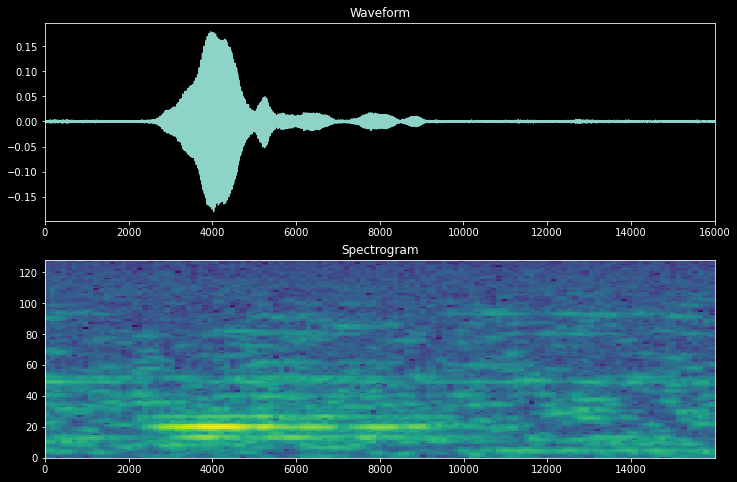

In [18]:
batch_size = 64

data_dir = tf.keras.utils.get_file(
                'mini_speech_commands.zip',
                extract=True,
                origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip'
            )
data_dir = data_dir[:-4]
commands = np.array(tf.io.gfile.listdir(data_dir))
commands = commands[commands != 'README.md']
print('Commands:', commands)
filenames = tf.io.gfile.glob(data_dir+'/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Total Number of Examples:', num_samples)
print('Number of Examples per Label:', len(tf.io.gfile.listdir(data_dir + '/' + commands[0])))
train_files = filenames[:6400]
val_files = filenames[6400:6400+800]
test_files = filenames[-800:]

def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(filepath):
    parts = tf.strings.split(filepath, os.path.sep)
    return parts[-2]

def get_waveform_and_label(filepath):
    label = get_label(filepath)
    audio_binary = tf.io.read_file(filepath)
    waveform = decode_audio(audio_binary)
    return waveform, label


AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

# Showing sample waveforms
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(train_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode()
    ax.set_title(label)
plt.show()

def get_spectrogram(waveform):
    zero_padding = tf.zeros([16000]-tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

# Showing a sample audio clip
for waveform, label in train_ds.take(1):
    label = label.numpy().decode()
    spectrogram = get_spectrogram(waveform)
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram Shape:', spectrogram.shape)
print('Audio Playback')
display.display(display.Audio(waveform, rate=16000))

def plot_spectrogram(spectrogram, ax):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

# Showing a sample spectrogram and waveform
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

def process_ds(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.batch(batch_size)
    output_ds = output_ds.cache()
    output_ds = output_ds.prefetch(AUTOTUNE)
    return output_ds

test_ds = process_ds(test_files)
train_ds = process_ds(train_files)
val_ds = process_ds(val_files)

## Creating a Model

In [31]:
for spectrogram_batch, _ in train_ds.take(1):
    input_shape = spectrogram_batch[0,:,:,:].shape
num_labels = len(commands)

norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _ : x))

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.experimental.preprocessing.Resizing(32, 32),
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels)
])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_10 (Resizing)       (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_15 (Normalizat (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 12544)           

## Training the Model

In [32]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam()
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=2,
    verbose=1
)

epochs = 10
history = model.fit(
    train_ds,
    callbacks=[early_stopping_callback],
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/10
100/100 [==============================] - 11s 16ms/step - loss: 1.7279 - accuracy: 0.3756 - val_loss: 1.3419 - val_accuracy: 0.5537
Epoch 2/10
100/100 [==============================] - 1s 7ms/step - loss: 1.1370 - accuracy: 0.6009 - val_loss: 1.0130 - val_accuracy: 0.6637
Epoch 3/10
100/100 [==============================] - 1s 7ms/step - loss: 0.8527 - accuracy: 0.7009 - val_loss: 0.8246 - val_accuracy: 0.7387
Epoch 4/10
100/100 [==============================] - 1s 7ms/step - loss: 0.7178 - accuracy: 0.7436 - val_loss: 0.7978 - val_accuracy: 0.7550
Epoch 5/10
100/100 [==============================] - 1s 7ms/step - loss: 0.6111 - accuracy: 0.7850 - val_loss: 0.7545 - val_accuracy: 0.7638
Epoch 6/10
100/100 [==============================] - 1s 7ms/step - loss: 0.5394 - accuracy: 0.8070 - val_loss: 0.7177 - val_accuracy: 0.7987
Epoch 7/10
100/100 [==============================] - 1s 7ms/step - loss: 0.4717 - accuracy: 0.8313 - val_loss: 0.6485 - val_accuracy: 0.8000
Epoc

## Plotting Training Metrics

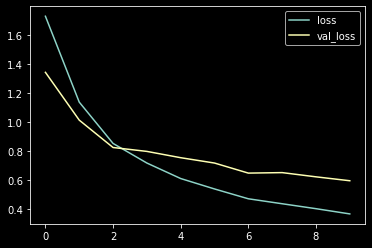

In [33]:
plt.plot(history.epoch, history.history['loss'], history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()